# Linear Regression Both Ways

A dummy dataset:

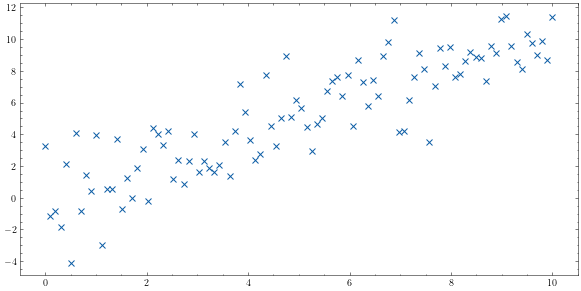

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
np.random.seed(1)

X_train = np.linspace(0,10,100)
noise = np.random.normal(0,2,100)
y_train = X_train + noise

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(X_train,y_train, marker='x');

plt.savefig("dataset")

We can define a linear model as:

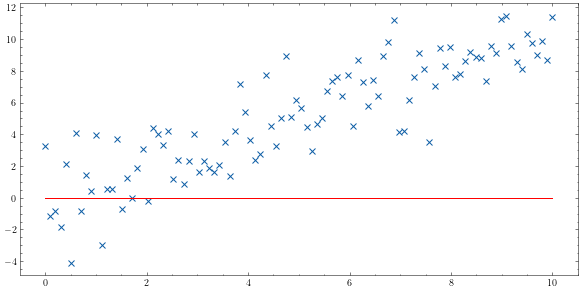

In [2]:
class Linear():
    theta = [0., 0.]
    
    def __call__(self, x):
        return np.sum(self.theta*x, axis=1)

model = Linear()
X = np.c_[np.ones(X_train.shape), X_train]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(X_train,y_train, marker='x')
ax.plot(X_train, model(X), color='red');

And the OLS loss function:

loss $ \mathcal{L} = (h_{\theta}(x) - y)^2$

In [3]:
def OLS(model, x, y):
    preds = model(x)
    return np.sum((preds - y)**2)

OLS(model, X, y_train)

3898.7122407196885

We want this cost value to be as low as possible. We can minimise the cost in two ways:
1. gradient descent
2. the normal equations

## Method 1: Gradient Descent

The gradient update rule is:  

$$
\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j}\mathcal{L}(\theta)
$$

To recap. We are making predictions $h_{\theta}(x)$ on $x$ with targets $y$. The loss is the squared difference between our prediction and the target: 

loss $ \mathcal{L} = (h_{\theta}(x) - y)^2$

### Taking the derivative of $\mathcal{L}$ wrt. $\theta_j$

We have a matrix $X$ of training examples so we can rewrite this as:

$\mathcal{L} = (X\theta - y)^\top(X\theta -y)$

We want the gradient $\nabla_{\theta}$ wrt. the loss:  


$
\begin{align}
\frac{\partial \theta}{\partial \mathcal{L}} & = \nabla_{\theta} \big[ (X\theta - y)^\top(X\theta - y) \big] \\
\end{align}
$

Before we take any gradients we can start with some rearranging:

$
= \nabla_{\theta} \big[ (X\theta)^\top X\theta - \color{teal}{(X\theta)^\top y} - y^\top(X\theta) - y^\top y\big]
$

Now we know that $a^{\top}b = b^{\top}a$ so we can rewrite the expression $\color{teal}{(X\theta)^\top y}$ as $y^\top(X\theta)$.

$
\begin{align}
& = \nabla_{\theta} \big[ (X\theta)^{\top} X\theta - 2y^\top(X\theta) - y^\top y \big] \\
\end{align}
$


The term $y^\top (X\theta)$ can be rearranged as $(X^\top y)^\top \theta$ (this can be verified by drawing out the row and column pictures as explained [here](http://cs229.stanford.edu/notes2020fall/notes2020fall/TA-slides1.pdf)).


So we're left with:

$
\begin{align}
& = \nabla_{\theta} \big[ (X\theta)^{\top} X\theta - 2(X^\top y)^\top \theta - y^\top y \big] \\
& = \nabla_{\theta} \big[ \theta^\top (X^\top X)\theta - 2(X^\top y)^\top \theta  - y^\top y \big]
\end{align}
$

Now we can take gradients. First step: remove $y^\top y$ because we're taking the gradient wrt. $\theta$ and that term doesn't involve $\theta$ at all:

$
\begin{align}
& = \nabla_{\theta} \big[ \theta^\top (X^\top X)\theta - 2(X^\top y)^\top \theta]
\end{align}
$

Now we just have two terms to take the gradients of.

There are two gradient rules to memorise:  

**Magic rule 1**
$
\begin{align}
& \color{teal}{\nabla_{\theta} a^\top \theta = a} \\
\end{align}
$

**Magic rule 2**
$
\begin{align}
& \color{violet}{\nabla_\theta \theta^\top A \theta = 2A\theta} \\
\end{align}
$

$
\begin{align}
& = \nabla_\theta \big[ \color{violet}{\theta^\top (X^\top X)\theta} - \color{teal}{2(X^\top y)^\top \theta}\big] \\
& = \color{violet}{2 (X^\top X)\theta} - \color{teal}{2(X^\top y)} \\
& = \color{violet}{(X^\top X)\theta} - \color{teal}{X^\top y} \\
\end{align}
$

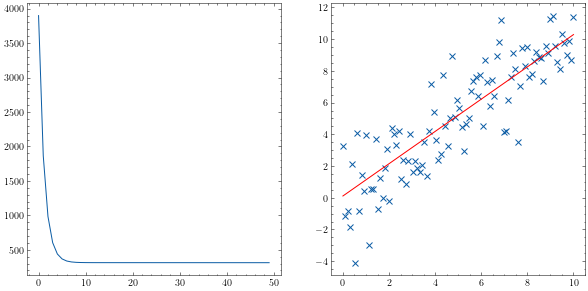

In [4]:
class Linear():
    # note because we sum over all the examples
    # we need a smol learning rate
    alpha = 1e-4
    theta = np.array([0., 0.])

    def update(self, X, y):
        grads = (X.T @ X) @ self.theta - X.T @ y
        self.theta = self.theta - self.alpha * grads
        
    def __call__(self, X):   
        self.preds = np.einsum('ij, j -> i', X, self.theta)
        return self.preds
    
def train(x, y, model, epochs):
    costs = []
    for epoch in range(epochs):
        preds = model(x)
        costs.append(OLS(model,x,y))
        model.update(x,y)
    return costs

x = X
y = y_train
model = Linear()
epochs = 50

costs = train(x,y,model,epochs=epochs)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(epochs), costs)
ax[1].scatter(X_train,y_train, marker='x')
ax[1].plot(X_train, model(X), color='red');

## Method 2: normal equations

We can also solve this particular setup analytically via the usual way:
1. take the derivative of $\mathcal{L}$ wrt. $\theta$
2. solve for derivative $=0$ 

In the case of linear regression there is only one solution (where the gradient = 0) so we know this will be where the loss is minimal.

### Step 1: Take the derivative of $\mathcal{L}$ wrt. $\theta$

We actually already have this from earlier, it's:

$
\nabla_\theta = (X^\top X)\theta - X^\top y
$

### Step 2:  Solve for derivative equal to 0:

$
\begin{align}
0 & = (X^\top X)\theta - X^\top y\\
(X^\top X)\theta & = X^\top y\\
\theta & = (X^\top X)^{-1} X^\top y\\
\end{align}
$



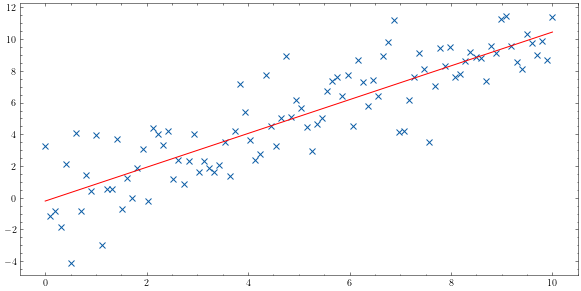

In [5]:
class Linear():
    theta = [0., 0.]
    
    def fit(self, X, y):
        self.theta = np.linalg.inv(X.T@X) @ np.dot(X.T, y)

    def __call__(self, x):
        self.preds = np.einsum('ij, j -> i', X, self.theta)
        return self.preds
        
model = Linear()
model.fit(x, y)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(X_train,y_train, marker='x')
ax.plot(X_train, model(X), color='red');